# <span style="color:#84b6f4;">Detección de emociones (felicidad)</span>

### <span style="color:#77dd77;">Conjuntos de datos de entrenamiento y prueba</span>

En este ejemplo, trataremos de clasificar imágenes, dependiendo de si el rostro que se muestra en ellas transmite o no felicidad. Para ello, utilizaremos conjuntos de datos de entrenamiento y prueba ya existentes, con rostros etiquetados para diferentes emociones:

In [1]:
import pandas as pd

df = pd.read_csv('resources/fer2013.csv')

# Filtrar solo las filas necesarias para entrenamiento y prueba
train_df = df[df['Usage'] == 'Training']
test_df = df[df['Usage'] == 'PublicTest']

Convertimos el problema a uno de clasificación binaria, centrándonos únicamente en la detección de imágenes felices:

In [2]:
import numpy as np

# Función para procesar los datos
def process_data(dataframe, happy_index):
    # Convertir los pixeles a una matriz numpy
    X = np.array([np.fromstring(pixels, sep=' ') for pixels in dataframe['pixels']])
    X = X.reshape(-1, 48, 48, 1)  # Reformatear en imágenes
    y = dataframe['emotion'].values
    y_binary = (y == happy_index).astype(int)  # 1 si 'Felicidad', 0 si no
    return X, y_binary

HAPPY_INDEX = 3

# Procesar los conjuntos de entrenamiento y prueba
X_train, y_train = process_data(train_df, HAPPY_INDEX)
X_test, y_test = process_data(test_df, HAPPY_INDEX)

# Normalizar las imágenes
X_train = X_train / 255.0
X_test = X_test / 255.0

# Función para limitar la clase sobrerrepresentada a un número máximo de muestras
def limit_class(X, y, target_class, max_samples):
    mask = (y == target_class)
    indices = np.where(mask)[0]
    if len(indices) > max_samples:
        indices = np.random.choice(indices, max_samples, replace=False)
    return X[indices], y[indices]

### <span style="color:#77dd77;">Balanceo de clases</span>

En el conjunto de entrenamiento hay un desbalance bastante notorio, por lo que debemos limitar la clase sobrerrepresentada y generar nuevas muestras de la clase subrepresentada para llegar a ese límite:

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Función para limitar la clase sobrerrepresentada a un número máximo de muestras
def limit_class(X, y, target_class, max_samples):
    mask = (y == target_class)
    indices = np.where(mask)[0]
    if len(indices) > max_samples:
        indices = np.random.choice(indices, max_samples, replace=False)
    return X[indices], y[indices]

# Limitar la clase "Not Happy" a 3000 muestras
X_train_not_happy, y_train_not_happy = limit_class(X_train, y_train, 0, 3000)

# Limitar la clase "Happy" a 3000 muestras
X_train_happy, y_train_happy = limit_class(X_train, y_train, 1, 3000)

# Combinar ambas clases
X_train_balanced = np.concatenate((X_train_not_happy, X_train_happy), axis=0)
y_train_balanced = np.concatenate((y_train_not_happy, y_train_happy), axis=0)

# Mezclar el conjunto balanceado
indices = np.random.permutation(len(X_train_balanced))
X_train_balanced = X_train_balanced[indices]
y_train_balanced = y_train_balanced[indices]

# Verificar el nuevo balance en el conjunto de entrenamiento
unique_balanced, counts_balanced = np.unique(y_train_balanced, return_counts=True)
print("\nConteo de etiquetas en el conjunto de entrenamiento balanceado:")
for label, count in zip(unique_balanced, counts_balanced):
    print(f"Felicidad: {label}, Cantidad: {count}")


Conteo de etiquetas en el conjunto de entrenamiento balanceado:
Felicidad: 0, Cantidad: 3000
Felicidad: 1, Cantidad: 3000


Mostramos ejemplos positivos y negativos para comprobar si el proceso se ha hecho correctamente:

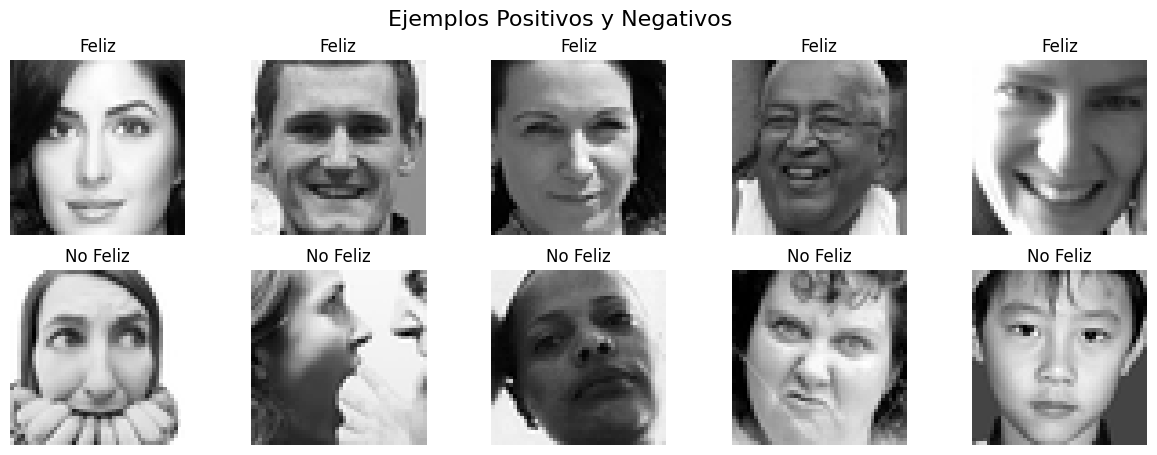

In [12]:
import random
import matplotlib.pyplot as plt

# Función para mostrar ejemplos visuales
def show_examples(X, y, num_pos=5, num_neg=5):
    pos_indices = np.where(y == 1)[0]
    neg_indices = np.where(y == 0)[0]

    fig, axes = plt.subplots(2, max(num_pos, num_neg), figsize=(15, 5))
    fig.suptitle("Ejemplos Positivos y Negativos", fontsize=16)

    for i, idx in enumerate(random.sample(list(pos_indices), num_pos)):
        axes[0, i].imshow(X[idx].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title("Feliz")

    for i, idx in enumerate(random.sample(list(neg_indices), num_neg)):
        axes[1, i].imshow(X[idx].squeeze(), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title("No Feliz")

    plt.show()

# Mostrar 5 ejemplos positivos y 5 negativos para comprobar la separación
show_examples(X_train_balanced, y_train_balanced, num_pos=5, num_neg=5)

Hacemos lo mismo con el conjunto de prueba, que también está desbalanceado:

In [13]:
# Limitar la clase "Not Happy" a 900 muestras en el conjunto de pruebas
X_test_not_happy, y_test_not_happy = limit_class(X_test, y_test, 0, 900)

# Limitar la clase "Happy" a 900 muestras en el conjunto de pruebas
X_test_happy, y_test_happy = limit_class(X_test, y_test, 1, 900)

# Combinar ambas clases en el conjunto de pruebas
X_test_balanced = np.concatenate((X_test_not_happy, X_test_happy), axis=0)
y_test_balanced = np.concatenate((y_test_not_happy, y_test_happy), axis=0)

# Mezclar el conjunto balanceado de pruebas
indices_test = np.random.permutation(len(X_test_balanced))
X_test_balanced = X_test_balanced[indices_test]
y_test_balanced = y_test_balanced[indices_test]

# Verificar el nuevo balance en el conjunto de pruebas
unique_balanced_test, counts_balanced_test = np.unique(y_test_balanced, return_counts=True)
print("\nConteo de etiquetas en el conjunto de pruebas balanceado:")
for label, count in zip(unique_balanced_test, counts_balanced_test):
    print(f"Felicidad: {label}, Cantidad: {count}")


Conteo de etiquetas en el conjunto de pruebas balanceado:
Felicidad: 0, Cantidad: 900
Felicidad: 1, Cantidad: 895


### <span style="color:#77dd77;">Entrenamiento</span>

Creamos un modelo de red neuronal convolucional (CNN) y lo entrenamos:

Epoch 1/30
188/188 [==============================] - 9s 42ms/step - loss: 0.6946 - accuracy: 0.5255 - val_loss: 0.6811 - val_accuracy: 0.5432
Epoch 2/30
188/188 [==============================] - 7s 39ms/step - loss: 0.6329 - accuracy: 0.6428 - val_loss: 0.5765 - val_accuracy: 0.6953
Epoch 3/30
188/188 [==============================] - 7s 38ms/step - loss: 0.5493 - accuracy: 0.7207 - val_loss: 0.5234 - val_accuracy: 0.7393
Epoch 4/30
188/188 [==============================] - 7s 38ms/step - loss: 0.5176 - accuracy: 0.7458 - val_loss: 0.4930 - val_accuracy: 0.7521
Epoch 5/30
188/188 [==============================] - 8s 40ms/step - loss: 0.4891 - accuracy: 0.7693 - val_loss: 0.4804 - val_accuracy: 0.7627
Epoch 6/30
188/188 [==============================] - 8s 44ms/step - loss: 0.4735 - accuracy: 0.7707 - val_loss: 0.4779 - val_accuracy: 0.7543
Epoch 7/30
188/188 [==============================] - 7s 36ms/step - loss: 0.4611 - accuracy: 0.7792 - val_loss: 0.4641 - val_accuracy: 0.7660

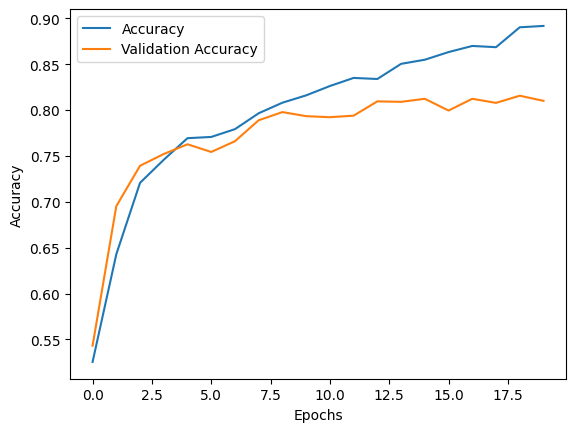

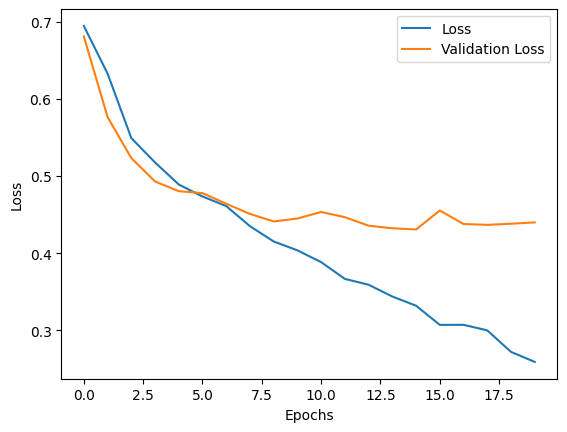

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Definir el modelo
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Definir la devolución de llamada de detención temprana
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Entrenar el modelo
history = model.fit(
    x=X_train_balanced,
    y=y_train_balanced,
    validation_data=(X_test_balanced, y_test_balanced),
    epochs=30,
    callbacks=[early_stopping]
)

# Mostrar los resultados del entrenamiento
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### <span style="color:#77dd77;">Evaluación</span>

Evaluamos los resultados del modelo, utilizando métricas como la precisión, el F1-score y la matriz de confusión:

57/57 [==============================] - 0s 6ms/step

Reporte de Clasificación:
               precision    recall  f1-score   support

   Not Happy       0.82      0.79      0.81       900
       Happy       0.80      0.83      0.81       895

    accuracy                           0.81      1795
   macro avg       0.81      0.81      0.81      1795
weighted avg       0.81      0.81      0.81      1795



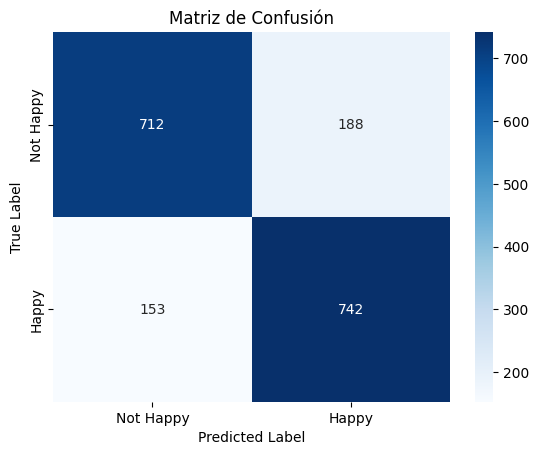

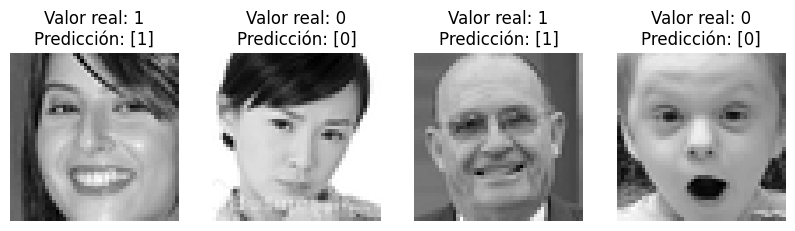

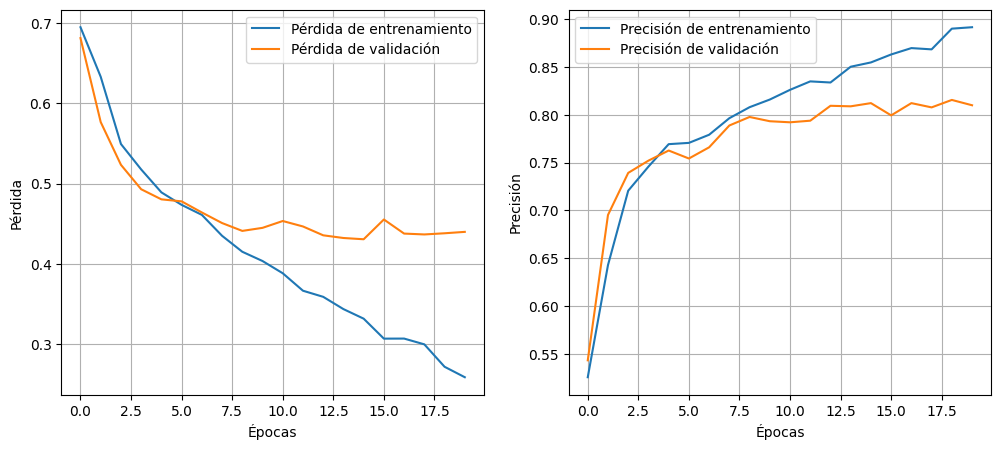

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random

# Evaluación del modelo
y_pred = (model.predict(X_test_balanced) > 0.5).astype(int)

# Generar el reporte de clasificación y la matriz de confusión
report = classification_report(y_test_balanced, y_pred, target_names=['Not Happy', 'Happy'])
print("\nReporte de Clasificación:\n", report)

# Crear y visualizar la matriz de confusión
cm = confusion_matrix(y_test_balanced, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Happy', 'Happy'], yticklabels=['Not Happy', 'Happy'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matriz de Confusión')
plt.show()

# Mostrar 4 ejemplos del conjunto de pruebas con sus predicciones
def show_evaluated_examples(X, y_true, y_pred, num_examples=4):
    indices = random.sample(range(len(X)), num_examples)
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_examples, i+1)
        plt.imshow(X[idx].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f'Valor real: {y_true[idx]}\nPredicción: {y_pred[idx]}')
    plt.show()

show_evaluated_examples(X_test_balanced, y_test_balanced, y_pred, num_examples=4)

# Gráfico del progreso de entrenamiento
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

plt.show()

Para finalizar, exportamos el modelo:

In [16]:
from joblib import dump

# Guardamos el modelo
model_filename = 'happy_detection.joblib'
dump(model, model_filename)

['happy_detection.joblib']